# NEMO LAMMPS bench

## Notes on benchmark on JUWELS (intel)

* hybrid of intel and opt fastest --> try more sophisticated settings here
* KOKKOS bench failed ?


For simulations using kspace_style pppm on Intel CPUs supporting AVX-512:

*    Add “kspace_modify diff ad” to the input script
*    The command-line option should be changed to “-pk intel 0 omp R lrt yes -sf intel” where R is the number of threads minus 1.
*    Do not use thread affinity (set KMP_AFFINITY=none)
*    The “newton off” setting may provide better scalability


intel choices

* newton setting: N on off (default on)  
  > Changing the newton setting to off can improve performance 
  > and/or scalability for simple 2-body potentials such as 
  > lj/cut or when using LRT mode on processors supporting AVX-512.
* NUMA mapping: m 1 0 (default 0)  
  > For simulations on higher node counts, add processors * * * grid numa 
  > to the beginning of the input script for better scalability.
* run_style verlet/power: p 1 0 (default 0)
  > The verlet/split style can only be used if LAMMPS was built 
  > with the REPLICA package. Correspondingly the respa/omp style
  > is available only if the USER-OMP package was included.
  > See the Build package doc page for more info.
* collectives for PPPM: c 1 0 (default 0)
* diff ad for PPPM: d 1 0 (default 1)  
  > The USER-INTEL package will perform better with modifications 
  > to the input script when PPPM is used: kspace_modify diff ad 
  > should be added to the input script.


>Not all styles are supported in the USER-INTEL package. You can mix the USER-INTEL package with styles from the OPT package or the USER-OMP package. Of course, this requires that these packages were installed at build time. This can performed automatically by using “-sf hybrid intel opt” or “-sf hybrid intel omp” command-line options. Alternatively, the “opt” and “omp” suffixes can be appended manually in the input script. For the latter, the package omp command must be in the input script or the “-pk omp Nt” command-line switch must be used where Nt is the number of OpenMP threads. The number of OpenMP threads should not be set differently for the different packages. Note that the suffix hybrid intel omp command can also be used within the input script to automatically append the “omp” suffix to styles when USER-INTEL styles are not available.

>When running on many nodes, performance might be better when using fewer OpenMP threads and more MPI tasks. This will depend on the simulation and the machine. Using the verlet/split run style might also give better performance for simulations with PPPM electrostatics. Note that this is an alternative to LRT mode and the two cannot be used together.

>Currently, when using Intel MPI with Intel Xeon Phi x200 series CPUs, better performance might be obtained by setting the environment variable “I_MPI_SHM_LMT=shm” for Linux kernels that do not yet have full support for AVX-512. Runs on Intel Xeon Phi x200 series processors will always perform better using MCDRAM. Please consult your system documentation for the best approach to specify that MPI runs are performed in MCDRAM.

> For “hybrid”, two packages are specified. The first is used whenever available. If a style with the first suffix is not available, the style with the suffix for the second package will be used if available. For example, “hybrid intel omp” will use styles from the USER-INTEL package as a first choice and styles from the USER-OMP package as a second choice if no USER-INTEL variant is available.

In [2]:
%load_ext autoreload
%autoreload 2
%config Application.log_level="DEBUG"

In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [4]:
import logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger()
logger.setLevel(logging.INFO)

In [5]:
from tabulate import tabulate
from pprint import pprint

In [6]:
import datetime
import glob
import os
import re
import shutil
import subprocess

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as scp
import scipy.constants as C
import scipy.interpolate

In [7]:
from fireworks.utilities.filepad import FilePad 

In [8]:
fp = FilePad(
    host='localhost',
    port=27018,
    database='fireworks-jhoermann',
    username='fireworks',
    password='fireworks')

In [9]:
query = {
    'metadata.surfactant':     'SDS',
    'metadata.type': 'benchmark results',
    'metadata.machine':  'NEMO'}

In [10]:
files = fp.get_file_by_query(query)

In [11]:
len(files)

68

In [12]:
parameter_names = ["nodes", "ppn", "ewald_accuracy", "coulomb_cutoff", "skin_distance", "neigh_delay", "neigh_every"]

In [13]:
#plotData = []
#do_print = False
parameter_dict = { p: [] for p in parameter_names }

decoded_logs = []
#stats_file = '20190412_stats.txt'
for (cont,doc) in files:
    try:
        for p in parameter_names:
            parameter_dict[p].append(doc['metadata'][p])
    except:
        logger.warning("Not key '{:s}' in file '{:s}' metadata! Skipped.".format(p, doc['identifier']))
        continue
    
    #contStream = io.StringIO(cont.decode())
    decoded_logs.append( cont.decode("utf-8", "strict") )
    print('.',end='')
print('.')
    

....................................................................


In [14]:
parameter_df = pd.DataFrame(parameter_dict)

In [15]:
regex_pattern_file = '/mnt/dat/work/testuser/adsorption/N_surfactant_on_substrate_template/regex/lmp_performance.regex'

In [16]:
with open(regex_pattern_file,'r') as f:
    regex_pattern = f.read()
    regex = re.compile(regex_pattern,flags=(re.MULTILINE | re.DEBUG) )

MAX_REPEAT 0 MAXREPEAT
  IN
    CATEGORY CATEGORY_SPACE
    CATEGORY CATEGORY_NOT_SPACE
LITERAL 10
LITERAL 76
LITERAL 111
LITERAL 111
LITERAL 112
LITERAL 32
LITERAL 116
LITERAL 105
LITERAL 109
LITERAL 101
LITERAL 32
LITERAL 111
LITERAL 102
LITERAL 32
SUBPATTERN 1 0 0
  MAX_REPEAT 0 1
    IN
      LITERAL 45
      LITERAL 43
  MAX_REPEAT 0 MAXREPEAT
    IN
      RANGE (48, 57)
  MAX_REPEAT 0 1
    LITERAL 46
  MAX_REPEAT 1 MAXREPEAT
    IN
      RANGE (48, 57)
  MAX_REPEAT 0 1
    SUBPATTERN 2 0 0
      IN
        LITERAL 101
        LITERAL 69
      MAX_REPEAT 0 1
        IN
          LITERAL 45
          LITERAL 43
      MAX_REPEAT 1 MAXREPEAT
        IN
          RANGE (48, 57)
LITERAL 32
LITERAL 111
LITERAL 110
LITERAL 32
SUBPATTERN 3 0 0
  MAX_REPEAT 0 1
    IN
      LITERAL 45
      LITERAL 43
  MAX_REPEAT 1 MAXREPEAT
    IN
      CATEGORY CATEGORY_DIGIT
LITERAL 32
LITERAL 112
LITERAL 114
LITERAL 111
LITERAL 99
LITERAL 115
LITERAL 32
LITERAL 102
LITERAL 111
LITERAL 114
LITERAL 32


SUBPATTERN None 0 0
  MAX_REPEAT 1 MAXREPEAT
    IN
      NEGATE None
      CATEGORY CATEGORY_SPACE
MAX_REPEAT 1 MAXREPEAT
  NOT_LITERAL 124
MAX_REPEAT 1 MAXREPEAT
  SUBPATTERN None 0 0
    LITERAL 124
    MAX_REPEAT 0 MAXREPEAT
      IN
        CATEGORY CATEGORY_SPACE
    SUBPATTERN 24 0 0
      MAX_REPEAT 0 1
        IN
          LITERAL 45
          LITERAL 43
      MAX_REPEAT 0 MAXREPEAT
        IN
          RANGE (48, 57)
      MAX_REPEAT 0 1
        LITERAL 46
      MAX_REPEAT 1 MAXREPEAT
        IN
          RANGE (48, 57)
      MAX_REPEAT 0 1
        SUBPATTERN 25 0 0
          IN
            LITERAL 101
            LITERAL 69
          MAX_REPEAT 0 1
            IN
              LITERAL 45
              LITERAL 43
          MAX_REPEAT 1 MAXREPEAT
            IN
              RANGE (48, 57)
    MAX_REPEAT 0 MAXREPEAT
      IN
        CATEGORY CATEGORY_SPACE
LITERAL 10
SUBPATTERN None 0 0
  MAX_REPEAT 1 MAXREPEAT
    IN
      NEGATE None
      CATEGORY CATEGORY_SPACE
MAX_REPEAT 

SUBPATTERN 54 0 0
  MAX_REPEAT 0 1
    IN
      LITERAL 45
      LITERAL 43
  MAX_REPEAT 1 MAXREPEAT
    IN
      CATEGORY CATEGORY_DIGIT
LITERAL 32
SUBPATTERN 55 0 0
  MAX_REPEAT 0 1
    IN
      LITERAL 45
      LITERAL 43
  MAX_REPEAT 1 MAXREPEAT
    IN
      CATEGORY CATEGORY_DIGIT
LITERAL 32
SUBPATTERN 56 0 0
  MAX_REPEAT 0 1
    IN
      LITERAL 45
      LITERAL 43
  MAX_REPEAT 1 MAXREPEAT
    IN
      CATEGORY CATEGORY_DIGIT
LITERAL 10
MAX_REPEAT 0 MAXREPEAT
  IN
    CATEGORY CATEGORY_SPACE
LITERAL 115
LITERAL 116
LITERAL 101
LITERAL 110
LITERAL 99
LITERAL 105
LITERAL 108
LITERAL 32
LITERAL 111
LITERAL 114
LITERAL 100
LITERAL 101
LITERAL 114
LITERAL 32
LITERAL 61
LITERAL 32
SUBPATTERN 57 0 0
  MAX_REPEAT 0 1
    IN
      LITERAL 45
      LITERAL 43
  MAX_REPEAT 1 MAXREPEAT
    IN
      CATEGORY CATEGORY_DIGIT
LITERAL 10
MAX_REPEAT 0 MAXREPEAT
  IN
    CATEGORY CATEGORY_SPACE
LITERAL 101
LITERAL 115
LITERAL 116
LITERAL 105
LITERAL 109
LITERAL 97
LITERAL 116
LITERAL 101
LITERAL 10

In [17]:
m = regex.match(decoded_logs[0])

In [18]:
data_raw = {}
for i, log in enumerate(decoded_logs):
    try:
        m = regex.match(log)
        data_raw[i] = m.groupdict()
        print('.',end='')
    except:
        logger.warning("Error parsing log no. {:d}!".format(i))
print('.')

....................................................................


In [21]:
performance_data_df = pd.DataFrame.from_dict(data_raw, orient='index')

In [22]:
performance_data_df.columns

Index(['looptime', 'nprocs', 'nsteps', 'natoms', 'ns_per_day', 'hours_per_ns',
       'timesteps_per_second', 'cpu_use', 'mpi_tasks', 'omp_threads',
       'share_pair', 'share_bond', 'share_kspace', 'share_neigh', 'share_comm',
       'share_output', 'share_modify', 'share_other', 'nlocal_ave',
       'nlocal_max', 'nlocal_min', 'nghost_ave', 'nghost_max', 'nghost_min',
       'neighs_ave', 'neighs_max', 'neighs_min', 'total_no_of_neighbors',
       'ave_neighs_per_atom', 'ave_special_neighs_per_atom',
       'neigh_list_builds', 'neigh_list_dangerous_builds', 'k_g_vector',
       'kgrid_nx', 'kgrid_ny', 'kgrid_nz', 'k_stencil_order',
       'k_absolute_rms_force_accuracy', 'k_relative_rms_force_accuracy',
       'k_grid_points_per_proc', 'k_fft_values_per_proc', 'total_wall_time'],
      dtype='object')

In [23]:
for column in performance_data_df.columns:
    try:
        performance_data_df[column] = pd.to_numeric( performance_data_df[column] )
    except:
        logger.warning("Error parsing parameter '{:s}' as number, trying time!".format(column))
        try:
            performance_data_df[column] = pd.to_timedelta( performance_data_df[column] )
        except:
            logger.warning("Error parsing parameter '{:s}' as time!".format(column))


In [24]:
performance_data_df.dtypes

looptime                                 float64
nprocs                                     int64
nsteps                                     int64
natoms                                     int64
ns_per_day                               float64
hours_per_ns                             float64
timesteps_per_second                     float64
cpu_use                                  float64
mpi_tasks                                  int64
omp_threads                                int64
share_pair                               float64
share_bond                               float64
share_kspace                             float64
share_neigh                              float64
share_comm                               float64
share_output                             float64
share_modify                             float64
share_other                              float64
nlocal_ave                               float64
nlocal_max                                 int64
nlocal_min          

In [25]:
bench_df = bench_per_cpu_df.join(bench_df).sort_index(axis=1) # sort_index along columns puts the higher levels (type) together

NameError: name 'bench_per_cpu_df' is not defined

In [26]:
bench_df = parameter_df.join(performance_data_df)

In [27]:
bench_df.head()["natoms"]

0    377228
1    377228
2    377228
3    377228
4    377228
Name: natoms, dtype: int64

In [28]:
grouped = bench_df.groupby(['nodes'])


In [29]:
parameter_names

['nodes',
 'ppn',
 'ewald_accuracy',
 'coulomb_cutoff',
 'skin_distance',
 'neigh_delay',
 'neigh_every']

In [30]:
parameter_names

['nodes',
 'ppn',
 'ewald_accuracy',
 'coulomb_cutoff',
 'skin_distance',
 'neigh_delay',
 'neigh_every']

In [31]:
column_selection = ['ewald_accuracy', 'coulomb_cutoff', 'skin_distance', 'neigh_delay', 
    'neigh_every','ns_per_day', 'cpu_use', 'share_pair', 'share_bond', 'share_kspace', 
    'share_neigh', 'share_comm', 'share_output', 'share_modify', 'share_other', 
    'nlocal_ave', 'neigh_list_builds', 'neigh_list_dangerous_builds', 'total_wall_time' ]

In [32]:
bench_nodes_2_selection_df = bench_df[ bench_df["nodes"] == 2 ].sort_values(by='ns_per_day',ascending=False)[column_selection]

In [33]:
bench_nodes_8_selection_df = bench_df[ bench_df["nodes"] == 8 ].sort_values(by='ns_per_day',ascending=False)[column_selection]

In [34]:
bench_nodes_2_selection_df.head(10).style.apply(lambda x: ['background: red' if x.neigh_list_dangerous_builds > 0 else '' for i in x],  axis=1)

,ewald_accuracy,coulomb_cutoff,skin_distance,neigh_delay,neigh_every,ns_per_day,cpu_use,share_pair,share_bond,share_kspace,share_neigh,share_comm,share_output,share_modify,share_other,nlocal_ave,neigh_list_builds,neigh_list_dangerous_builds,total_wall_time
17,0.0001,12,2,10,1,0.951,99.2,71.84,0.22,11.56,10.69,1.2,0,4.34,0.16,9430.7,100,100,0 days 00:03:06
13,0.0001,12,2,10,5,0.949,99.2,71.66,0.22,11.74,10.67,1.2,0,4.35,0.16,9430.7,100,100,0 days 00:03:07
50,0.0001,8,2,2,1,0.937,98.3,62.29,0.22,15.58,13.58,1.29,0,6.82,0.22,9430.7,125,0,0 days 00:03:09
12,0.0001,12,3,10,5,0.935,99.1,72.82,0.22,12.9,8.28,1.21,0,4.39,0.18,9430.7,67,1,0 days 00:03:09
20,0.0001,12,3,4,2,0.933,99.1,72.82,0.21,12.51,8.69,1.21,0,4.36,0.2,9430.7,71,0,0 days 00:03:10
16,0.0001,12,3,10,1,0.933,99.1,72.8,0.21,12.39,8.82,1.21,0,4.37,0.2,9430.7,72,1,0 days 00:03:10
24,0.0001,12,3,2,1,0.928,99.1,72.19,0.21,12.87,8.87,1.21,0,4.43,0.21,9430.7,72,0,0 days 00:03:11
21,0.0001,12,2,4,2,0.92,99.2,69.72,0.21,11.68,12.8,1.21,0,4.2,0.17,9430.7,123,0,0 days 00:03:13
26,0.0001,10,2,2,1,0.92,99,69.16,0.21,11.66,12.93,1.22,0,4.61,0.2,9430.7,125,0,0 days 00:03:13
11,0.0001,12,4,10,5,0.918,99,75.02,0.21,12.71,6.22,1.21,0,4.42,0.19,9430.7,40,0,0 days 00:03:13


In [35]:
bench_nodes_8_selection_df.head(10).style.apply(lambda x: ['background: red' if x.neigh_list_dangerous_builds > 0 else '' for i in x],  axis=1)

,ewald_accuracy,coulomb_cutoff,skin_distance,neigh_delay,neigh_every,ns_per_day,cpu_use,share_pair,share_bond,share_kspace,share_neigh,share_comm,share_output,share_modify,share_other,nlocal_ave,neigh_list_builds,neigh_list_dangerous_builds,total_wall_time
44,0.0001,8,2,2,1,3.509,98.5,56.99,0.2,19.09,13.14,2.46,0.01,7.76,0.34,2357.68,125,0,0 days 00:00:55
46,0.01,12,2,2,1,3.506,98.7,64.34,0.2,15.22,13.22,2.37,0.01,4.33,0.3,2357.68,127,0,0 days 00:00:55
34,0.0001,12,2,10,1,3.462,98.7,63.56,0.2,17.72,10.28,2.27,0.01,5.7,0.26,2357.68,100,100,0 days 00:00:55
47,0.001,12,2,2,1,3.381,98.8,62.15,0.2,17.67,12.76,2.29,0.01,4.62,0.3,2357.68,125,0,0 days 00:00:57
42,0.0001,12,3,2,1,3.367,98.6,64.88,0.2,17.79,8.84,2.34,0.01,5.56,0.38,2357.68,72,0,0 days 00:00:57
38,0.0001,12,3,4,2,3.336,98.6,64.35,0.19,18.45,8.75,2.33,0.01,5.6,0.33,2357.68,71,0,0 days 00:00:57
59,0.0001,8,3,18,9,3.317,98.5,57.32,0.19,18.64,12.57,2.31,0.01,8.7,0.26,2357.68,55,nan,0 days 00:00:58
49,0.0001,12,2,2,1,3.315,98.8,60.95,0.19,18.4,12.68,2.29,0.01,5.17,0.31,2357.68,126,0,0 days 00:00:58
48,1e-05,12,2,2,1,3.233,98.6,59.43,0.19,18.12,12.01,2.27,0.01,7.66,0.31,2357.68,125,0,0 days 00:00:59
56,0.0001,8,3,20,10,3.227,98.5,55.75,0.19,21.25,10.95,2.3,0.01,9.31,0.25,2357.68,50,nan,0 days 00:01:00


In [36]:
varied_coulomb_cutoff_selection = (bench_df["ewald_accuracy"] == 1.0e-4) & (bench_df["skin_distance"] == 2.0) & (bench_df["neigh_delay"] == 2) & (bench_df["neigh_every"] == 1)

varied_ewald_accuracy_selection = (bench_df["coulomb_cutoff"] == 12.0) & (bench_df["skin_distance"] == 2.0) & (bench_df["neigh_delay"] == 2) & (bench_df["neigh_every"] == 1)

varied_skin_distance_selection = (bench_df["coulomb_cutoff"] == 12.0) & (bench_df["ewald_accuracy"] == 1.0e-4) & (bench_df["neigh_delay"] == 2) & (bench_df["neigh_every"] == 1)

varied_neigh_delay_selection = (bench_df["skin_distance"] == 2.0) & (bench_df["coulomb_cutoff"] == 12.0) & (bench_df["ewald_accuracy"] == 1.0e-4)  & (bench_df["neigh_every"] == 1)

In [37]:
np.count_nonzero(varied_coulomb_cutoff_selection)

10

In [38]:
column_selection = ['coulomb_cutoff','ns_per_day', 'cpu_use', 'share_pair', 'share_bond', 'share_kspace', 
    'share_neigh', 'share_comm', 'share_output', 'share_modify', 'share_other', 'neigh_list_builds', 'neigh_list_dangerous_builds', 'total_wall_time' ]

In [39]:

print(bench_df[ (bench_df["nodes"] == 8) & varied_coulomb_cutoff_selection ].sort_values(by='coulomb_cutoff',ascending=False)[column_selection].to_string())

    coulomb_cutoff  ns_per_day  cpu_use  share_pair  share_bond  share_kspace  share_neigh  share_comm  share_output  share_modify  share_other  neigh_list_builds  neigh_list_dangerous_builds total_wall_time
43            14.0       2.071     99.0       60.45        0.12         20.94        13.00        1.73          0.00          3.51         0.25                126                          0.0        00:01:29
49            12.0       3.315     98.8       60.95        0.19         18.40        12.68        2.29          0.01          5.17         0.31                126                          0.0        00:00:58
7             10.0       3.158     98.8       58.14        0.18         20.69        12.32        2.23          0.01          6.10         0.33                125                          0.0        00:01:00
44             8.0       3.509     98.5       56.99        0.20         19.09        13.14        2.46          0.01          7.76         0.34                125      

In [40]:
def plot_bench(sel,x,y='ns_per_day',per_line_property='nodes', per_line_values=[2,8]):
    if not isinstance(per_line_property, list):
        per_line_property = [ per_line_property ]
    for val in per_line_values:
        plt.plot( 
            bench_df[ bench_df[per_line_property].eq(val).all(axis=1) & sel ].sort_values(by=x,ascending=False)[x],
            bench_df[ bench_df[per_line_property].eq(val).all(axis=1) & sel ].sort_values(by=x,ascending=False)[y],
            label = ' '.join(per_line_property) + ': {}'.format(val), marker='o', linestyle='--',)
    plt.xlabel(x)
    plt.ylabel(y)
    plt.legend()

In [41]:
def plot_xlog_bench(sel,x,y='ns_per_day',per_line_property='nodes', per_line_values=[2,8]):
    if not isinstance(per_line_property, list):
        per_line_property = [ per_line_property ]
    for val in per_line_values:
        plt.semilogx( 
            bench_df[ bench_df[per_line_property].eq(val).all(axis=1) & sel ].sort_values(by=x,ascending=False)[x],
            bench_df[ bench_df[per_line_property].eq(val).all(axis=1) & sel ].sort_values(by=x,ascending=False)[y],
            label = ' '.join(per_line_property) + ': {}'.format(val),  marker='o', linestyle='--')
    plt.xlabel(x)
    plt.ylabel(y)
    plt.legend()

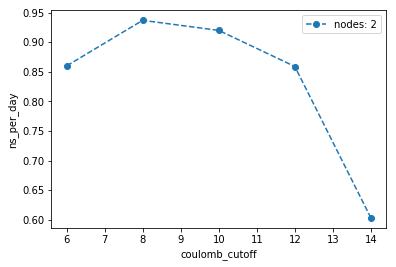

In [42]:
plot_bench(varied_coulomb_cutoff_selection, 'coulomb_cutoff', per_line_property='nodes', per_line_values=[2])

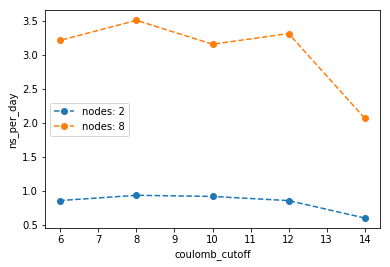

In [43]:
plot_bench(varied_coulomb_cutoff_selection, 'coulomb_cutoff')

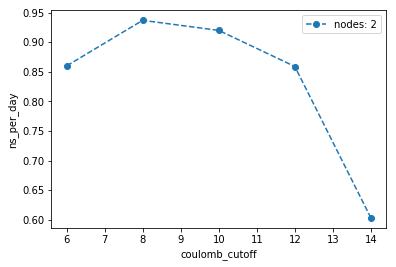

In [44]:
plot_bench(varied_coulomb_cutoff_selection, 'coulomb_cutoff', per_line_property='nodes', per_line_values=[2])

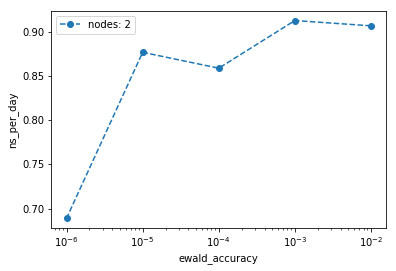

In [45]:
plot_xlog_bench(varied_ewald_accuracy_selection, 'ewald_accuracy', per_line_property='nodes', per_line_values=[2])

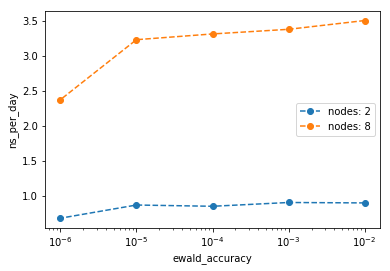

In [46]:
plot_xlog_bench(varied_ewald_accuracy_selection, 'ewald_accuracy', per_line_property='nodes', per_line_values=[2,8])

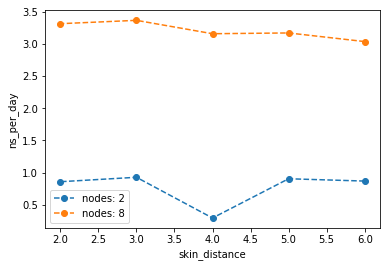

In [47]:
plot_bench(varied_skin_distance_selection, 'skin_distance', per_line_property='nodes', per_line_values=[2,8])

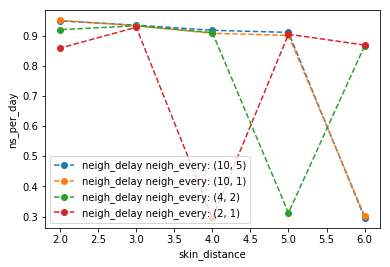

In [48]:
plot_bench( (bench_df["nodes"] == 2) &(bench_df["coulomb_cutoff"] == 12.0) & (bench_df["ewald_accuracy"] == 1.0e-4), 'skin_distance', per_line_property=['neigh_delay','neigh_every'], 
           per_line_values=[(10,5),(10,1),(4,2),(2,1)])

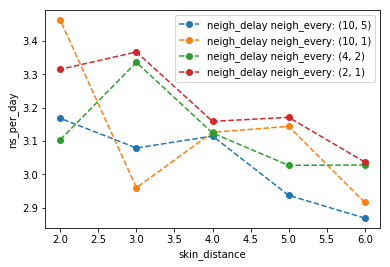

In [49]:
plot_bench( (bench_df["nodes"] == 8) &(bench_df["coulomb_cutoff"] == 12.0) & (bench_df["ewald_accuracy"] == 1.0e-4), 'skin_distance', per_line_property=['neigh_delay','neigh_every'], 
           per_line_values=[(10,5),(10,1),(4,2),(2,1)])

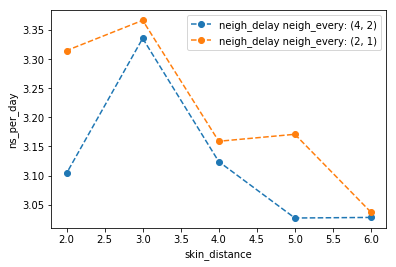

In [50]:
plot_bench( (bench_df["nodes"] == 8) &(bench_df["coulomb_cutoff"] == 12.0) & (bench_df["ewald_accuracy"] == 1.0e-4), 'skin_distance', per_line_property=['neigh_delay','neigh_every'], 
           per_line_values=[(4,2),(2,1)])

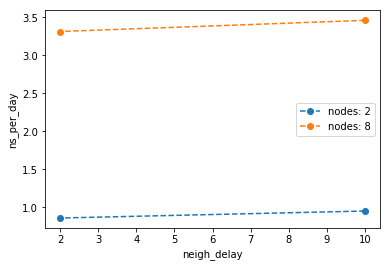

In [51]:
plot_bench( varied_neigh_delay_selection, 'neigh_delay', per_line_property=['nodes'], 
           per_line_values=[2,8])

In [52]:
parameter_set = {}
for p in parameter_names:
    if p is not 'ppn':
        parameter_set[p] = list(bench_df[p].unique())

In [53]:
from pprint import pprint

In [60]:
parameter_set

{'nodes': [2, 8],
 'ewald_accuracy': [0.0001, 1e-06, 1e-05, 0.01, 0.001],
 'coulomb_cutoff': [12.0, 10.0, 14.0, 8.0, 6.0],
 'skin_distance': [6.0, 5.0, 4.0, 3.0, 2.0],
 'neigh_delay': [10, 4, 2, 20, 18, 16, 14, 12, 8, 6],
 'neigh_every': [5, 1, 2, 10, 9, 8, 7, 6, 4, 3]}

In [61]:
list(parameter_set.keys())

['nodes',
 'ewald_accuracy',
 'coulomb_cutoff',
 'skin_distance',
 'neigh_delay',
 'neigh_every']

In [56]:
print(tabulate( [ (k, *v) for k,v in parameter_set.items() ] ) )

--------------  -------  ------  ------  -----  ------  --  --  --  -  -
nodes            2        8
ewald_accuracy   0.0001   1e-06   1e-05   0.01   0.001
coulomb_cutoff  12       10      14       8      6
skin_distance    6        5       4       3      2
neigh_delay     10        4       2      20     18      16  14  12  8  6
neigh_every      5        1       2      10      9       8   7   6  4  3
--------------  -------  ------  ------  -----  ------  --  --  --  -  -


In [57]:
grouped = bench_df.groupby(parameter_names)

In [58]:
grouped.count()

looptime  \
nodes ppn ewald_accuracy coulomb_cutoff skin_distance neigh_delay neigh_every             
2     20  0.000001       12.0           2.0           2           1                   1   
          0.000010       12.0           2.0           2           1                   1   
          0.000100       6.0            2.0           2           1                   1   
                         8.0            2.0           2           1                   1   
                         10.0           2.0           2           1                   1   
                         12.0           2.0           2           1                   1   
                                                      4           2                   1   
                                                      10          1                   1   
                                                                  5                   1   
                                        3.0           2           1                   1   
                                                      4           2                   1   
                                                      10          1                   1   
                                                                  5                   1   
                                        4.0           2           1                   1   
                                                      4           2                   1   
                                                      10          1                   1   
                                                                  5                   1   
                                        5.0           2           1                   1   
                                                      4           2                   1   
                                                      10          1                   1   
                                                                  5                   1   
                                        6.0           2           1                   1   
                                                      4           2                   1   
                                                      10          1                   1   
                                                                  5                   1   
                         14.0           2.0           2           1                   1   
          0.001000       12.0           2.0           2           1                   1   
          0.010000       12.0           2.0           2           1                   1   
8     20  0.000001       12.0           2.0           2           1                   1   
          0.000010       12.0           2.0           2           1                   1   
...                                                                                 ...   
          0.000100       8.0            3.0           10          5                   1   
                                                      12          6                   1   
                                                      14          7                   1   
                                                      16          8                   1   
                                                      18          9                   1   
                                                      20          10                  1   
                         10.0           2.0           2           1                   1   
                         12.0           2.0           2           1                   1   
                                                      4           2                   1   
                                                      10          1                   1   
                                                                  5                   1   
                                        3.0           2           1        

In [59]:
bench_df[ (bench_df["nodes"] == 8) & (bench_df["neigh_delay"] == 10) ].sort_values(by='ns_per_day',ascending=False)[column_selection]

,coulomb_cutoff,ns_per_day,cpu_use,share_pair,share_bond,share_kspace,share_neigh,share_comm,share_output,share_modify,share_other,neigh_list_builds,neigh_list_dangerous_builds,total_wall_time
34,12.0,3.462,98.7,63.56,0.20,17.72,10.28,2.27,0.01,5.70,0.26,100,100.0,00:00:55
30,12.0,3.168,98.8,58.37,0.18,23.02,10.07,2.18,0.01,5.92,0.25,100,100.0,00:01:01
32,12.0,3.144,98.4,66.14,0.18,20.59,4.41,2.43,0.01,5.88,0.37,26,0.0,00:01:01
33,12.0,3.126,98.6,63.43,0.18,21.55,6.52,2.24,0.01,5.72,0.36,44,0.0,00:01:00
4,12.0,3.115,98.6,63.36,0.18,22.00,6.19,2.22,0.01,5.77,0.28,41,0.0,00:01:01
29,12.0,3.079,98.7,59.45,0.18,24.53,8.15,2.13,0.01,5.32,0.24,66,0.0,00:01:02
5,12.0,2.960,98.8,57.17,0.17,25.07,8.47,2.11,0.01,6.72,0.29,72,0.0,00:01:04
28,12.0,2.937,98.5,61.86,0.17,24.35,4.17,2.39,0.01,6.74,0.31,26,0.0,00:01:05
31,12.0,2.916,98.3,65.07,0.17,22.31,3.45,2.60,0.01,5.98,0.41,18,0.0,00:01:05
27,12.0,2.869,98.3,64.05,0.17,23.23,3.20,2.48,0.01,6.53,0.34,17,0.0,00:01:06


In [415]:
bench_df[ (bench_df["nodes"] == 8) & (bench_df["ewald_accuracy"] == 1e-4) ].sort_values(by='ns_per_day',ascending=False)[column_selection]

,coulomb_cutoff,ns_per_day,cpu_use,share_pair,share_bond,share_kspace,share_neigh,share_comm,share_output,share_modify,share_other,neigh_list_builds,neigh_list_dangerous_builds,total_wall_time
44,8.0,3.509,98.5,56.99,0.20,19.09,13.14,2.46,0.01,7.76,0.34,125,0,00:00:55
34,12.0,3.462,98.7,63.56,0.20,17.72,10.28,2.27,0.01,5.70,0.26,100,100,00:00:55
42,12.0,3.367,98.6,64.88,0.20,17.79,8.84,2.34,0.01,5.56,0.38,72,0,00:00:57
38,12.0,3.336,98.6,64.35,0.19,18.45,8.75,2.33,0.01,5.60,0.33,71,0,00:00:57
49,12.0,3.315,98.8,60.95,0.19,18.40,12.68,2.29,0.01,5.17,0.31,126,0,00:00:58
45,6.0,3.215,98.3,50.84,0.19,22.51,12.39,2.34,0.01,11.38,0.35,127,0,00:00:59
40,12.0,3.171,98.4,66.73,0.18,19.99,4.34,2.47,0.01,5.87,0.40,26,0,00:01:00
30,12.0,3.168,98.8,58.37,0.18,23.02,10.07,2.18,0.01,5.92,0.25,100,100,00:01:01
41,12.0,3.159,98.6,64.16,0.18,20.75,6.67,2.30,0.01,5.56,0.36,44,0,00:01:00
7,10.0,3.158,98.8,58.14,0.18,20.69,12.32,2.23,0.01,6.10,0.33,125,0,00:01:00


In [175]:
bench_nodes_8_selection_df.style.apply(lambda x: ['background: red' if x.neigh_list_dangerous_builds > 0 else '' for i in x],  axis=1) 

,ewald_accuracy,coulomb_cutoff,skin_distance,neigh_delay,neigh_every,ns_per_day,cpu_use,share_pair,share_bond,share_kspace,share_neigh,share_comm,share_output,share_modify,share_other,nlocal_ave,neigh_list_builds,neigh_list_dangerous_builds,total_wall_time
44,0.0001,8,2,2,1,3.509,98.5,56.99,0.2,19.09,13.14,2.46,0.01,7.76,0.34,2357.68,125,0,0 days 00:00:55
46,0.01,12,2,2,1,3.506,98.7,64.34,0.2,15.22,13.22,2.37,0.01,4.33,0.3,2357.68,127,0,0 days 00:00:55
34,0.0001,12,2,10,1,3.462,98.7,63.56,0.2,17.72,10.28,2.27,0.01,5.7,0.26,2357.68,100,100,0 days 00:00:55
47,0.001,12,2,2,1,3.381,98.8,62.15,0.2,17.67,12.76,2.29,0.01,4.62,0.3,2357.68,125,0,0 days 00:00:57
42,0.0001,12,3,2,1,3.367,98.6,64.88,0.2,17.79,8.84,2.34,0.01,5.56,0.38,2357.68,72,0,0 days 00:00:57
38,0.0001,12,3,4,2,3.336,98.6,64.35,0.19,18.45,8.75,2.33,0.01,5.6,0.33,2357.68,71,0,0 days 00:00:57
49,0.0001,12,2,2,1,3.315,98.8,60.95,0.19,18.4,12.68,2.29,0.01,5.17,0.31,2357.68,126,0,0 days 00:00:58
48,1e-05,12,2,2,1,3.233,98.6,59.43,0.19,18.12,12.01,2.27,0.01,7.66,0.31,2357.68,125,0,0 days 00:00:59
45,0.0001,6,2,2,1,3.215,98.3,50.84,0.19,22.51,12.39,2.34,0.01,11.38,0.35,2357.68,127,0,0 days 00:00:59
40,0.0001,12,5,2,1,3.171,98.4,66.73,0.18,19.99,4.34,2.47,0.01,5.87,0.4,2357.68,26,0,0 days 00:01:00


In [417]:
bench_pivot_list_df = pd.pivot_table(bench_df, values='ns_per_day', 
               index=['nodes','skin_distance','coulomb_cutoff','ewald_accuracy','neigh_every','neigh_delay'])

In [418]:
bench_pivot_grid_df = pd.pivot_table(bench_df, values='ns_per_day', 
               index=['nodes','skin_distance','coulomb_cutoff'], 
               columns=['ewald_accuracy','neigh_every','neigh_delay'])

In [419]:
bench_pivot_list_df.replace(np.nan,'')

ns_per_day
nodes skin_distance coulomb_cutoff ewald_accuracy neigh_every neigh_delay            
2     2.0           6.0            0.000100       1           2                 0.860
                    8.0            0.000100       1           2                 0.937
                    10.0           0.000100       1           2                 0.920
                    12.0           0.000001       1           2                 0.689
                                   0.000010       1           2                 0.877
                                   0.000100       1           2                 0.859
                                                              10                0.951
                                                  2           4                 0.920
                                                  5           10                0.949
                                   0.001000       1           2                 0.913
                                   0.010000       1           2                 0.907
                    14.0           0.000100       1           2                 0.603
      3.0           12.0           0.000100       1           2                 0.928
                                                              10                0.933
                                                  2           4                 0.933
                                                  5           10                0.935
      4.0           12.0           0.000100       1           2                 0.295
                                                              10                0.908
                                                  2           4                 0.910
                                                  5           10                0.918
      5.0           12.0           0.000100       1           2                 0.905
                                                              10                0.901
                                                  2           4                 0.312
                                                  5           10                0.911
      6.0           12.0           0.000100       1           2                 0.869
                                                              10                0.302
                                                  2           4                 0.866
                                                  5           10                0.296
8     2.0           6.0            0.000100       1           2                 3.215
                    8.0            0.000100       1           2                 3.509
                    10.0           0.000100       1           2                 3.158
                    12.0           0.000001       1           2                 2.377
                                   0.000010       1           2                 3.233
                                   0.000100       1           2                 3.315
                                                              10                3.462
                                                  2           4                 3.104
                                                  5           10                3.168
                                   0.001000       1           2                 3.381
                                   0.010000       1           2                 3.506
                    14.0           0.000100       1           2                 2.071
      3.0           12.0           0.000100       1           2                 3.367
                                                              10                2.960
                                                  2           4                 3.336
                                                  5           10                3.079
      4.0           12.0           0.000100       1           2                 3.159
                                 

In [420]:
np.nanmax(bench_pivot_grid_df.values)

3.509

AttributeError: module 'pandas' has no attribute 'isnumeric'

In [437]:
pd.api.types.is_numeric_dtype(str)

False

In [444]:
bench_pivot_grid_df.replace(np.nan,'').style.applymap(lambda x: 'background: lightgreen' if (pd.api.types.is_numeric_dtype(type(x)) and np.greater_equal(x,0.9*np.nanmax(bench_pivot_grid_df.values))) else '' )